# Analyzing 1-step QAOA on non-triangle-free graphs

This is heavily based on work in https://ui.adsabs.harvard.edu/abs/2018PhRvA..97b2304W/ . 

In their Theorem 1, they prove a formula for $\langle C_{uv} \rangle$, assuming node $u$ has $d_u + 1$ neighbors, node $v$ has $d_v + 1$ neighbors, and there are $\lambda_{uv}$ triangles containing $E_{uv}$.

$$
\langle C_{uv} \rangle = 1/2 + (1/4)sin(4\beta)sin(\gamma)(cos^{d_u}(\gamma) + cos^{d_v}(\gamma)) - (1/4)sin^2(\beta) cos^{d_u + d_v - 2\lambda_{uv}}(\gamma)(1 - cos^{\lambda_{uv}}(2\gamma))
$$

On a D-regular graph, when the subgraphs are identical (assuming $Y$ triangles per subgraph), the number of cut edges is $K = (DN/2) \langle C_{uv}\rangle$. In this case, $\langle C_{uv} \rangle = 1/2 + \delta$:

$$
\delta = (1/2)sin(4\beta)sin(\gamma)cos^{D-1}(\gamma) - (1/4)sin^2(\beta)cos^{2(D-1-Y)}(\gamma)(1-cos^Y(2\gamma))
$$

For QAOA, the angles $(\gamma, \beta)$ are typically optimized to maximize $\delta$.

The triangle-free case is described in their work, finding maximum angles $(\gamma, \beta) = (\arctan(1/\sqrt{D-1}), \pi/8)$. This can be proved by taking $(d\delta/d\gamma)$ and $(d\delta/d\beta)$, respectively. They also find $\delta$:

$$
\delta_{max} = (1/2)D^{-0.5}(1-1/D)^{(D-1)/2} > (1/2)D^{-0.5}e^{-0.5}
$$

The inequality follows because $\sqrt{(1-1/D)^D}$ tends towards $\sqrt{e^{-1}}$. 

---

## Finding maximum angle with triangles

I did not solve this analytically. Instead, I use a grid search over $\gamma$ and $\beta$:

In [1]:
from numpy import sin, cos, linspace, pi, e
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def delta_triangles(beta, gamma, D, Y):
    """This calculates delta, given a D-regular graph with Y triangles related to each edge."""
    t1 = 0.5*sin(4*beta)*sin(gamma)*(cos(gamma)**(D-1))
    t2 = 0.25*(sin(beta)**2)*(cos(gamma)**(2*(D-1-Y)))*(1-(cos(2*gamma)**Y))
    return t1 - t2

In [3]:
def get_max(D, Y, try_optimal_value = False):
    """This searches over beta and gamma to find the optimal value of delta."""
    results = []
    for beta in linspace(0, 2*pi, 128):
        results += [delta_triangles(beta, gamma, D, Y) for gamma in linspace(0, 2*pi, 128)]
        if try_optimal_value:
            # test optimal gamma choice for triangle-free graphs
            results.append(delta_triangles(beta, np.arctan((D-1)**-0.5), d, f))
    return max(results)

### Plots

This search should match the optimal value closely for triangle-free graphs.

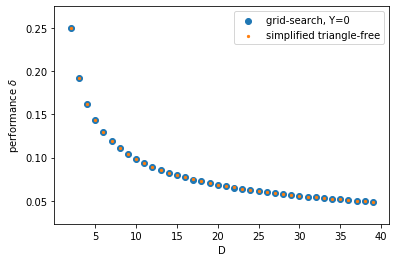

In [4]:
# This compares delta = Cuv - 1/2 from search vs the known optimal value for triangle-free graphs.
Y=0
inputs = range(2, 40)
plt.scatter(inputs, [get_max(D, Y) for D in inputs], label="grid-search, Y=0")
plt.scatter(inputs, [(1 - 1/D)**((D-1)/2) * 1/2 * D**-0.5 for D in inputs], s=5, label="simplified triangle-free")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()

How does this vary with Y? The performance gets worse with more triangles, but not by much.

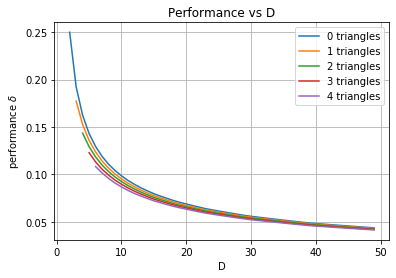

In [5]:
for Y in range(5):
    inputs = range(2+Y, 50)
    plt.plot(inputs, [get_max(D, Y) for D in inputs], label=str(Y) + " triangles")
plt.legend()
plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.grid()

In [ ]:
for Y in range(0, 10, 2):
    inputs = range(2+Y, 50)
    plt.plot(inputs, [get_max(D, Y)*(D**0.5) for D in inputs], label=str(Y) + " triangles")
plt.legend()
plt.title("Scaled performance vs D (might tend towards constant $C = \delta \sqrt{D}$)")
plt.xlabel("D")
plt.ylabel("$\delta \sqrt{D}$")
plt.legend()
plt.grid(True)

---

# TODO  from here

## todo - Optimizations
* Memoize results in cuv triangles so it only takes a long time to run once


## todo - Analytical result
* Could try to solve optimal value analytically for f=1, or f=2, etc?
* Could try to solve optimal value generally for f?

$$
〈Cuv〉(d,f)  =1/2+1/2sin 4βsinγ(cos^dγ)−1/4sin^2βcos^{2(d−f)}γ(1−cos^f2γ)
$$


## todo - Comparison with Hastings + triangles
started july 10
* it looks like Hastings does worse with many triangles, or at least takes a high D to catch up. Verify this. Why might this be?
* one triangle to one triangle, Hastings catches up by D=20-30.
* two triangles to two triangles, Hastings catches up by D=60-75.
* maybe, in limit of D, Hastings will win, but with many triangles, Hastings algorithm is not that good?
    * it makes sense. Hastings depends on the $E_{ij}$ having an impact on modifying $i$ but not $j$, or vice versa. If many neighbors are shared, it limits the impact of $E_{ij}$ being in the max cut (i.e. $i$ and $j$ being differently colored).

In [ ]:
# if beta = pi/8, then the last term has this much weight compared to the triangle-free term
sin(pi/8)**2/2

In [ ]:
def test(x, d, f):
    """something to find the max of"""
    return sin(x) * cos(x)**d - .073* cos(x)**(2*d-2*f) * (1 - cos(2*x)**f)

In [ ]:
d=15
for f in range(d):
    inputs = np.linspace(0,pi, 4096)
    outputs = [test(x, d, f) for x in inputs]
    plt.plot(inputs/pi, outputs, label=str(f) + " triangles")
    print(max(outputs), "cot^2(gamma):", np.tan(inputs[outputs.index(max(outputs))])**-2)
plt.xlabel("gamma value * pi")
plt.ylabel("Cuv")
plt.title('D=' + str(d))
plt.legend()

Assuming Beta = pi/8, the maximum gamma value does not change by much, but it does get slightly less with more triangles.